Loaded data from: C:\Users\MSAF\Downloads\car data.csv
Shape: (301, 9)


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0



Target stats (Selling_Price):
count    301.000000
mean       4.661296
std        5.082812
min        0.100000
25%        0.900000
50%        3.600000
75%        6.000000
max       35.000000
Name: Selling_Price, dtype: float64

Classification label distribution (0=Low,1=Medium,2=High):
Selling_Price
1    104
0    100
2     97
Name: count, dtype: int64

Numerical columns: ['Year', 'Present_Price', 'Driven_kms', 'Owner', 'car_age', 'kms_per_year']
Categorical columns: ['Car_Name', 'Fuel_Type', 'Selling_type', 'Transmission', 'brand']

Train shape: (240, 11) Test shape: (61, 11)

================ REGRESSION MODELS =================

▶ LinearRegression
RMSE: 1.7380 | MAE: 1.1796 | R2: 0.8266
▶ Ridge
RMSE: 1.5396 | MAE: 1.0423 | R2: 0.8639
▶ Lasso
RMSE: 2.6323 | MAE: 1.8342 | R2: 0.6022
▶ DecisionTreeRegressor
RMSE: 1.8378 | MAE: 0.8100 | R2: 0.8061
▶ RandomForestRegressor
RMSE: 1.7326 | MAE: 0.7412 | R2: 0.8277
▶ ExtraTreesRegressor
RMSE: 0.6649 | MAE: 0.4342 | R2: 0.9746
▶ GradientBoostin

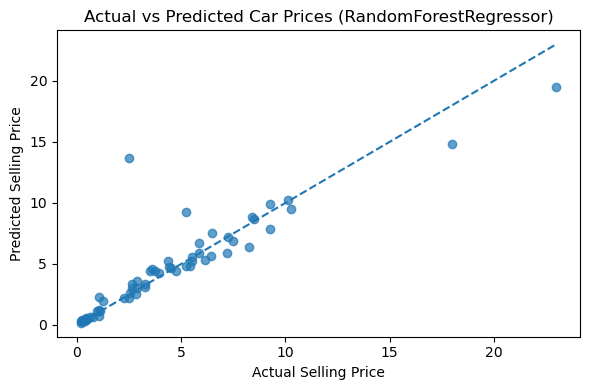


✅ TASK 3 Completed: Data preprocessing, feature engineering, multiple models, evaluation, and visualization done.


In [1]:
# ============================================================
# TASK 3: Car Price Prediction with Machine Learning
# End-to-end script: load data, preprocess, feature engineer,
# train multiple regression & classification models,
# evaluate, and visualize.
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# --- Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, confusion_matrix, classification_report
)

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, HistGradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from IPython.display import display

# ============================================================
# STEP 1: LOAD DATA
# ============================================================

DATA_PATH = r"C:\Users\MSAF\Downloads\car data.csv"   # <-- your dataset
TARGET = "Selling_Price"                              # price column

df = pd.read_csv(DATA_PATH)
print("Loaded data from:", DATA_PATH)
print("Shape:", df.shape)
display(df.head())

# ============================================================
# STEP 2: BASIC CLEANING & FEATURE ENGINEERING
# ============================================================

data = df.copy()
data.columns = [c.strip() for c in data.columns]

# Convert "numeric-looking" strings to numeric
for col in data.columns:
    if data[col].dtype == object:
        s = data[col].astype(str).str.replace(',', '').str.replace('₹', '').str.strip()
        sample = s.dropna().head(30)
        if not sample.empty and sample.apply(lambda v: v.replace('.', '', 1).isdigit()).all():
            data[col] = pd.to_numeric(s, errors='coerce')

CURRENT_YEAR = datetime.datetime.now().year

# Feature: car age
if 'Year' in data.columns:
    data['car_age'] = CURRENT_YEAR - data['Year']

# Feature: kms per year
if 'Driven_kms' in data.columns and 'car_age' in data.columns:
    data['kms_per_year'] = data['Driven_kms'] / data['car_age'].replace({0: 1})

# Feature: brand from Car_Name
if 'Car_Name' in data.columns:
    data['brand'] = data['Car_Name'].astype(str).apply(lambda x: x.split()[0])

# ============================================================
# STEP 3: TARGETS (Regression + Classification)
# ============================================================

if TARGET not in data.columns:
    raise ValueError(f"Target column '{TARGET}' not found. Check your CSV.")

# Keep only rows with non-null target
data = data[data[TARGET].notna()].reset_index(drop=True)
y_reg = pd.to_numeric(data[TARGET], errors='coerce')

# Drop non-numeric target rows
mask_valid = y_reg.notna()
data = data[mask_valid].reset_index(drop=True)
y_reg = y_reg[mask_valid].reset_index(drop=True)

print("\nTarget stats (Selling_Price):")
print(y_reg.describe())

# Classification target: Low/Medium/High based on quantiles
q1, q2 = y_reg.quantile([0.33, 0.66])

def price_to_category(v):
    if v <= q1:
        return 0   # Low
    elif v <= q2:
        return 1   # Medium
    else:
        return 2   # High

y_clf = y_reg.apply(price_to_category)
print("\nClassification label distribution (0=Low,1=Medium,2=High):")
print(y_clf.value_counts())

# ============================================================
# STEP 4: FEATURES + PREPROCESSING
# ============================================================

X = data.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumerical columns:", num_cols)
print("Categorical columns:", cat_cols)

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline (for sklearn >=1.4 use sparse_output instead of sparse)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

# Train-test split
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)

# ============================================================
# STEP 5: REGRESSION MODELS & EVALUATION
# ============================================================

regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "SVR": SVR(),
    "MLPRegressor": MLPRegressor(max_iter=700),
    "AdaBoostRegressor": AdaBoostRegressor()
}

def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # no squared kwarg
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

print("\n================ REGRESSION MODELS =================\n")
regression_predictions = {}

for name, model in regressors.items():
    print(f"▶ {name}")
    try:
        reg_pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        reg_pipe.fit(X_train, y_reg_train)
        y_pred = reg_pipe.predict(X_test)
        evaluate_regression(y_reg_test, y_pred)
        regression_predictions[name] = (reg_pipe, y_pred)
    except Exception as e:
        print("  ❌ Error:", e)

# ============================================================
# STEP 6: CLASSIFICATION MODELS & EVALUATION
# ============================================================

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "GaussianNB": GaussianNB(),
    "MLPClassifier": MLPClassifier(max_iter=700),
    "AdaBoostClassifier": AdaBoostClassifier()
}

def evaluate_classification(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))

print("\n================ CLASSIFICATION MODELS =================\n")
for name, model in classifiers.items():
    print(f"▶ {name}")
    try:
        clf_pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", model)
        ])
        clf_pipe.fit(X_train, y_clf_train)
        y_pred_cls = clf_pipe.predict(X_test)
        evaluate_classification(y_clf_test, y_pred_cls)
    except Exception as e:
        print("  ❌ Error:", e)

# ============================================================
# STEP 7: VISUALIZATION (Matplotlib) - Actual vs Predicted
# ============================================================

# Use RandomForestRegressor for visualization (if it succeeded)
if "RandomForestRegressor" in regression_predictions:
    rf_pipe, rf_pred = regression_predictions["RandomForestRegressor"]
    plt.figure(figsize=(6, 4))
    plt.scatter(y_reg_test, rf_pred, alpha=0.7)
    plt.xlabel("Actual Selling Price")
    plt.ylabel("Predicted Selling Price")
    plt.title("Actual vs Predicted Car Prices (RandomForestRegressor)")
    # line y=x for reference
    min_val = min(y_reg_test.min(), rf_pred.min())
    max_val = max(y_reg_test.max(), rf_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
    plt.tight_layout()
    plt.show()
else:
    print("\n(RandomForestRegressor did not train successfully, so no plot was generated.)")

print("\n✅ TASK 3 Completed: Data preprocessing, feature engineering, multiple models, evaluation, and visualization done.")
